In [1]:
import numpy as np

import keras
import keras.backend as K
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

%config InlineBackend.fugure_format = 'retina'

%load_ext autoreload

/home/semyon/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
print(K.image_data_format())

channels_last


In [3]:
IMAGE_PATCH_SHAPE = (64, 64, 1)

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Lambda, Flatten, BatchNormalization, Activation
    
#WEIGHT_DECAY = 5e-4 / 2 for weight regularization
    
# siam-l2 from "Learning to Compare Image Patches via Convolutional Neural Networks"
descriptor = Sequential()

descriptor.add(Lambda(lambda x : (K.cast(x, 'int16') - 128) / 128, input_shape=IMAGE_PATCH_SHAPE))

descriptor.add(Conv2D(96, kernel_size=7, strides=3, input_shape=IMAGE_PATCH_SHAPE))
descriptor.add(BatchNormalization())
descriptor.add(Activation('relu'))
descriptor.add(MaxPooling2D(pool_size=2, strides=2))
descriptor.add(Dropout(0.2))

descriptor.add(Conv2D(192, kernel_size=5, strides=1))
descriptor.add(BatchNormalization())
descriptor.add(Activation('relu'))
descriptor.add(MaxPooling2D(pool_size=2, strides=2))
descriptor.add(Dropout(0.2))

descriptor.add(Conv2D(256, kernel_size=3, strides=1))
descriptor.add(BatchNormalization())
descriptor.add(Activation('relu'))
descriptor.add(Flatten())
descriptor.add(Lambda(lambda x : tf.nn.l2_normalize(x, axis=1))) # TODO check normalization

print(descriptor.input_shape, descriptor.output_shape)

(None, 64, 64, 1) (None, 256)


In [5]:
from keras.models import Model
from keras.layers import Input

input_a = Input(shape=IMAGE_PATCH_SHAPE)
input_b = Input(shape=IMAGE_PATCH_SHAPE)

descriptor_a = descriptor(input_a)
descriptor_b = descriptor(input_b)

def euclidean_distance(vects):
    assert len(vects) == 2
    x, y = vects
    return -(K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon())) - 1)

distance = Lambda(euclidean_distance)([descriptor_a, descriptor_b])
model = Model(inputs=[input_a, input_b], outputs=distance)

print(model.input_shape, model.output_shape)

[(None, 64, 64, 1), (None, 64, 64, 1)] (None, 1)


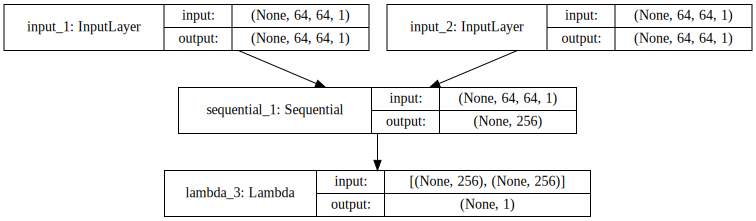

In [6]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [7]:
DATA_ROOT = '../data'
NOTREDAME = f'{DATA_ROOT}/notredame'
LIBERTY = f'{DATA_ROOT}/liberty'

!ls {NOTREDAME}/m50_*.txt

../data/notredame/m50_100000_100000_0.txt
../data/notredame/m50_10000_10000_0.txt
../data/notredame/m50_1000_1000_0.txt
../data/notredame/m50_200000_200000_0.txt
../data/notredame/m50_20000_20000_0.txt
../data/notredame/m50_2000_2000_0.txt
../data/notredame/m50_500000_500000_0.txt
../data/notredame/m50_50000_50000_0.txt
../data/notredame/m50_5000_5000_0.txt


In [8]:
from keras.losses import hinge
from keras.optimizers import Adam

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.sign(y_pred)), axis=-1)

model.compile(loss=hinge, optimizer=Adam(), metrics=[accuracy])

In [9]:
!rm -r siam-l2-logs

In [10]:
model.load_weights('siam-l2-weights.hdf5')

In [11]:
%autoreload
from utils import create_generator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from batchtensorboard import BatchTensorBoard

NUM_TRAIN_PAIRS = 500000
NUM_VAL_PAIRS = 100000
BATCH_SIZE = 128
NUM_TRAIN_STEPS = NUM_TRAIN_PAIRS // BATCH_SIZE
NUM_VAL_STEPS = NUM_VAL_PAIRS // BATCH_SIZE

train_generator = create_generator(NOTREDAME, NUM_TRAIN_PAIRS, BATCH_SIZE, augmentate=True)
validation_generator = create_generator(LIBERTY, NUM_VAL_PAIRS, BATCH_SIZE, augmentate=False)

tensorboard = BatchTensorBoard(log_dir='siam-l2-logs')
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000001)
checkpointer = ModelCheckpoint('siam-l2-weights.hdf5')

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=NUM_TRAIN_STEPS, epochs=100, 
    validation_data=validation_generator, validation_steps=NUM_VAL_STEPS, 
    callbacks=[tensorboard, lr_reducer, checkpointer])

Epoch 1/100
3906/3906 [==============================] - 321s 82ms/step - loss: 0.6121 - accuracy: 0.7900 - val_loss: 0.6911 - val_accuracy: 0.7338
Epoch 2/100
3906/3906 [==============================] - 305s 78ms/step - loss: 0.6125 - accuracy: 0.7924 - val_loss: 0.6876 - val_accuracy: 0.7345
Epoch 3/100
3906/3906 [==============================] - 315s 81ms/step - loss: 0.6120 - accuracy: 0.7931 - val_loss: 0.6834 - val_accuracy: 0.7365
Epoch 4/100
3905/3906 [============================>.] - ETA: 0s - loss: 0.6113 - accuracy: 0.7929

In [80]:
inputs, true = next(create_generator(LIBERTY, num_pairs=1000, batch_size=1000))
pred = model.predict(inputs, verbose=1)

1000/1000 [==============================] - 0s 442us/step


In [81]:
print(pred.reshape(-1)[-30:])

[ 0.81982386  0.9933566   0.97128004  0.9968581  -0.41421354 -0.41421354
 -0.41421342  0.9569182   0.7646918  -0.41421354 -0.41421354  0.9965077
  0.5328934  -0.41421354 -0.41421354 -0.41421342 -0.41421354  0.54169333
 -0.41421354 -0.41421366  0.99599564 -0.12486565  0.99677914 -0.41421354
  0.4828862   0.9905059   0.95777684  0.7905697   0.9969707  -0.41421354]


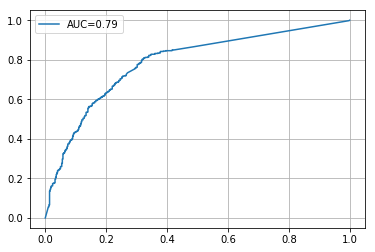

In [82]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(true, pred)
roc_auc = auc(fpr, tpr)
plt.grid()
plt.plot(fpr, tpr, label=f'AUC={roc_auc:0.2f}')
plt.legend()
plt.show()

In [83]:
model.layers

In [84]:
descr = model.layers[2]
embeddings = descr.predict(inputs[0])

In [85]:
from numpy.linalg import norm

sum(norm(e) for e in embeddings)

984.9999809861183